# hw8
---
We'd like to simulate the quantum key distribution. We first import packages and discuss a very simple case.

In [7]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit import BasicAer, execute
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

We assume Alice needs to send a message to Bob and it's $ |+\rangle $ in x basis. Then if Bob measures it also in x basis, he will get zero.

In [22]:
# define a quantum circuit
q = QuantumCircuit(QuantumRegister(1),ClassicalRegister(1))

# Alice sends the message 
q.h(0)
q.barrier()

# Bob receives and measures it
q.h(0)
q.measure(0,0)

# Draw the circuit
display(q.draw())


┌───┐ ░ ┌───┐┌─┐
q33_0: ┤ H ├─░─┤ H ├┤M├
       └───┘ ░ └───┘└╥┘
c12: 1/══════════════╩═
                     0


Total count for 00 and 11 are: {'0': 100}


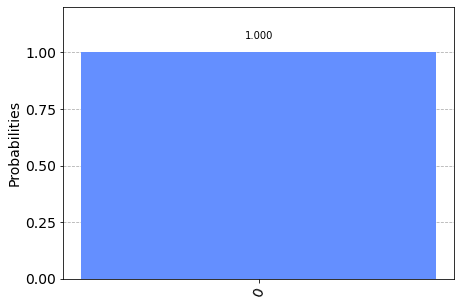

In [25]:
nshots = 100

# use Aer's simulator to transpile
simulator = QasmSimulator()
compiled_circuit = transpile(q, simulator)
result = simulator.run(compiled_circuit, shots=nshots).result()

# Returns counts
counts = result.get_counts(q)
print("\nTotal count for 00 and 11 are:",counts)
plot_histogram(result.get_counts())


Not surprisingly, Bob gets a zero. However, once a third party Eve trys to eavesdrop such messages, he will measure the qubit before it reaches Bob, which results in an uncertainty for Bob's measurement result.

In [32]:

# Alice sends the message 
q = QuantumCircuit(QuantumRegister(1),ClassicalRegister(1))
q.h(0)

# Eve measures it and then passes it to Bob
q.measure(0,0)
q.barrier()

# Bob receives and measures it
q.h(0)
q.measure(0,0)

# Draw the circuit
display(q.draw())

┌───┐┌─┐ ░ ┌───┐┌─┐
q67_0: ┤ H ├┤M├─░─┤ H ├┤M├
       └───┘└╥┘ ░ └───┘└╥┘
c13: 1/══════╩══════════╩═
             0          0


Total count for 00 and 11 are: {'1': 53, '0': 47}


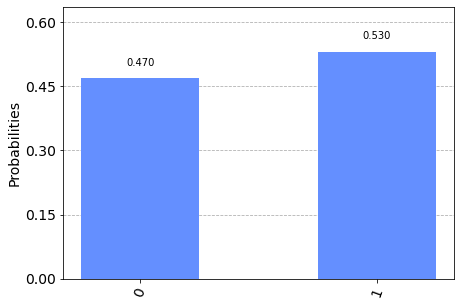

In [37]:
# use Aer's simulator to transpile
simulator = QasmSimulator()
compiled_circuit = transpile(q, simulator)
result = simulator.run(compiled_circuit, shots=nshots).result()

# Returns counts
counts = result.get_counts(q)
print("\nTotal count for 00 and 11 are:",counts)
plot_histogram(result.get_counts())


As we could see, Bob can no longer measure a certain value on X basis. Repeating above processes Bob could find out the conversation is being eavesdropping.